In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/IndianCurrencyDetection_keras.zip -d/content/

Archive:  /content/drive/MyDrive/IndianCurrencyDetection_keras.zip
   creating: /content/IndianCurrencyDetection_keras/
   creating: /content/IndianCurrencyDetection_keras/10/
   creating: /content/IndianCurrencyDetection_keras/100/
  inflating: /content/IndianCurrencyDetection_keras/100/100__101_jpg.rf.2d4d12cab8af2e5fc0ae297f8bfb87bc.jpg  
  inflating: /content/IndianCurrencyDetection_keras/100/100__101_jpg.rf.a9f144a05d8e176d71d14ef7bd3c6105.jpg  
  inflating: /content/IndianCurrencyDetection_keras/100/100__101_jpg.rf.c102fff4c6ceeb50f724ff1894747015.jpg  
  inflating: /content/IndianCurrencyDetection_keras/100/100__104_jpg.rf.4036f757fa350e6908058eef486901b8.jpg  
  inflating: /content/IndianCurrencyDetection_keras/100/100__104_jpg.rf.c3281c0fcd2b652df0182a6ffa742f99.jpg  
  inflating: /content/IndianCurrencyDetection_keras/100/100__104_jpg.rf.c87c0b7a53deac97f668dff20713d612.jpg  
  inflating: /content/IndianCurrencyDetection_keras/100/100__106_jpg.rf.54430923959133a306157a1517177

In [ ]:
import pathlib

data_dir = pathlib.Path('/content/IndianCurrencyDetection_keras').with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1233


In [ ]:
batch_size = 32
img_height = 180
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1233 files belonging to 7 classes.
Using 987 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1233 files belonging to 7 classes.
Using 246 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['10', '100', '20', '200', '2000', '50', '500']


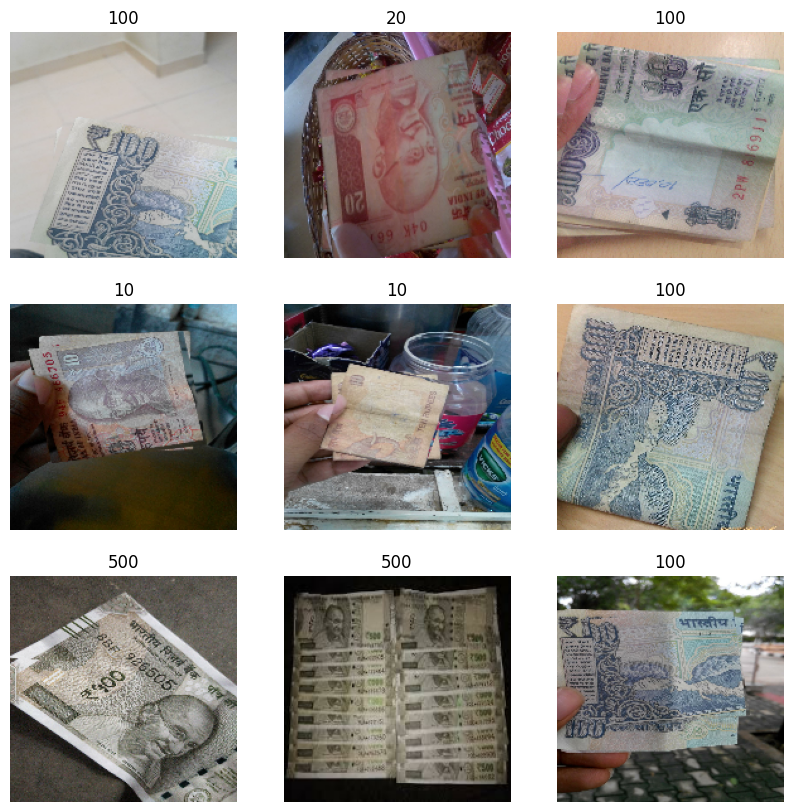

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.00017436908 0.98111844


In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

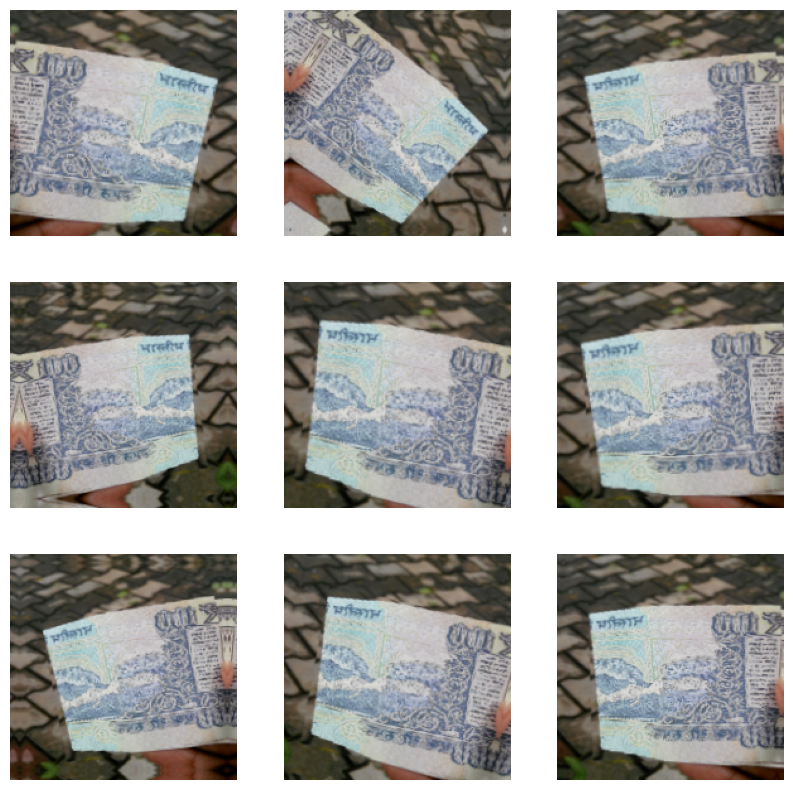

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [ ]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
31/31 [==============================] - 3s 37ms/step - loss: 2.0195 - accuracy: 0.2290 - val_loss: 1.8891 - val_accuracy: 0.2561
Epoch 2/30
31/31 [==============================] - 1s 30ms/step - loss: 1.8148 - accuracy: 0.2877 - val_loss: 1.8390 - val_accuracy: 0.2764
Epoch 3/30
31/31 [==============================] - 1s 32ms/step - loss: 1.6618 - accuracy: 0.3485 - val_loss: 1.7264 - val_accuracy: 0.3089
Epoch 4/30
31/31 [==============================] - 1s 36ms/step - loss: 1.4561 - accuracy: 0.4215 - val_loss: 1.4304 - val_accuracy: 0.4309
Epoch 5/30
31/31 [==============================] - 1s 33ms/step - loss: 1.2610 - accuracy: 0.5390 - val_loss: 1.2708 - val_accuracy: 0.5650
Epoch 6/30
31/31 [==============================] - 1s 31ms/step - loss: 1.0329 - accuracy: 0.6474 - val_loss: 1.1728 - val_accuracy: 0.5854
Epoch 7/30
31/31 [==============================] - 1s 31ms/step - loss: 0.9152 - accuracy: 0.6616 - val_loss: 0.8348 - val_accuracy: 0.7276
Epoch 8/30
31

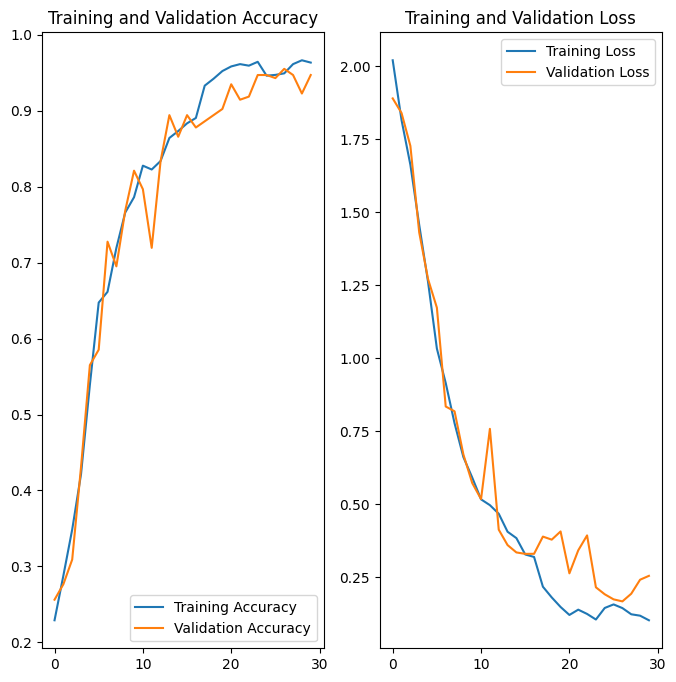

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
predict_path = pathlib.Path('/content/920.jpg')

img = tf.keras.utils.load_img(
    predict_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 261ms/step
This image most likely belongs to 20 with a 40.98 percent confidence.
